# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.524761,False,-0.781031
1,-0.189978,False,0.900473
2,0.493943,True,6.274869
3,0.206764,True,5.490949
4,0.577285,True,6.438748
...,...,...,...
995,-0.143068,False,-1.012807
996,-1.271734,False,-4.360007
997,0.231597,True,5.952515
998,-1.258180,False,-2.561490


<AxesSubplot:xlabel='v0'>

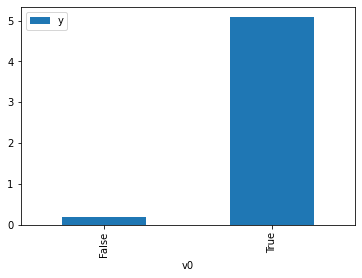

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

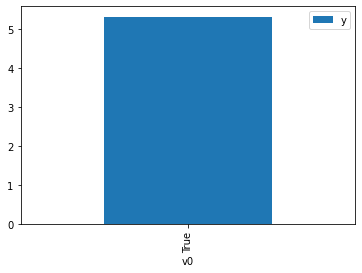

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.589072,False,2.699512,0.446664,2.238818
1,1.257905,False,3.689043,0.382813,2.612241
2,-0.608008,False,-0.766990,0.563996,1.773061
3,0.274294,False,-1.277265,0.477475,2.094349
4,-0.149603,False,0.470489,0.519196,1.926055
...,...,...,...,...,...
995,-0.968238,False,-4.100302,0.598519,1.670789
996,0.333799,False,-0.730733,0.471630,2.120304
997,-0.744930,False,-1.265624,0.577211,1.732469
998,-0.197642,False,0.713527,0.523918,1.908695


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.540220,True,-0.221054,0.348732,2.867528
1,-1.071576,True,3.027461,0.391739,2.552718
2,0.579456,True,7.350370,0.552399,1.810285
3,-0.459629,True,4.588371,0.450426,2.220118
4,0.411197,True,6.370300,0.535960,1.865811
...,...,...,...,...,...
995,1.429528,True,9.918534,0.633029,1.579708
996,-0.723206,True,2.279503,0.424879,2.353612
997,1.101549,True,6.314732,0.602534,1.659658
998,0.430945,True,7.324590,0.537894,1.859101


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.135e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        13:53:05   Log-Likelihood:                         -1438.9
No. Observations:                1000   AIC:                                      2882.
Df Residuals:                     998   BIC:                                      2892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6640      0.033     81.948      0.000       2.600       2.728
x2             5.0702      0.046    109.391      0.000       4.979       5.161
==============================================================================
Omnibus:                        1.447   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.452
Skew:                          -0.093   Prob(JB):                        0.484
Kurtosis:                       2.977   Cond. No.                         1.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""